## Imports

In [1]:
%matplotlib inline

# main imports
import os
import torch
import numpy as np
import matplotlib.pyplot as plt

# photontorch
import photontorch as pt

# other
from tqdm.notebook import trange # progress bars
from scipy.signal import butter, lfilter # bit smoothing

# mpl style context manager
custom_style = lambda : plt.style.context(os.path.abspath('custom.mplstyle'))

## Parameters

In [2]:
device = "cuda"
wl0 = 1.55e-6  # center wavelength
neff = 2.3557#2.34  # effective index
ng = 4.2#3.4  # group index of waveguide
loss = 300#1000  # [dB/m]
ring_length = 2*np.pi*5e-6#2*np.pi*5e-6
env = pt.Environment(
    wl_start=1.53e-6,
    wl_end=1.59e-6,
    num_wavelengths=1000,
    num_timesteps=1,
    frequency_domain=True,
    enable_grad=False,
)
pt.set_environment(env)

## Allpass

/home/flaport/Programming/Photontorch/photontorch/networks/network.py:640: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1596265861335/work/torch/csrc/utils/tensor_numpy.cpp:141.)
  device=self.device,


wl0=1554.5045045045044


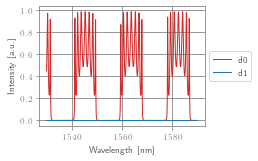

In [3]:
crow = (
    pt.RingNetwork(
        ring_length=ring_length, neff=neff, ng=ng, loss=loss, N=2, capacity=14
    )
    .to(device)
    .terminate()
    .initialize()
)

src = (crow.num_sources-1)//2
det = crow.num_sources-1 - src - crow.base.capacity//2%2
source = np.zeros(crow.num_sources)
source[src] = 1
detected = crow(source)
wl0 = env.wavelength[torch.argmin(detected[0,:,det,0])]*1e9
print(f'wl0={wl0}')

import os
with custom_style():
    crow.plot(detected)
    plt.grid()
    plt.show()

In [4]:
#wl0 = 1550

class Target(torch.nn.Module):
    def __init__(self):
        super(Target, self).__init__()
        self.sigma = torch.nn.Parameter(torch.tensor(0.5))
    def forward(self):
        return torch.exp(-(wls-wl0)**2/self.sigma**2)
    
class FlatbandTarget(torch.nn.Module):
    def __init__(self):
        super(FlatbandTarget, self).__init__()
        self.alpha = self.parameter(6)
        self.beta = self.parameter(-0.1)
        self.gamma = self.parameter(0.8)
    @staticmethod
    def parameter(x):
        param = torch.nn.Parameter(torch.tensor(
            x,
            dtype=torch.get_default_dtype(),
            device=device
        ))
        return param
    def forward(self):
        half_wls = wls[:len(wls)//2]
        x = 0.5*self.gamma*(torch.tanh(self.alpha*(half_wls-half_wls.mean()+self.beta))+1.0)
        middle = x[-1] if len(wls)%2 else torch.tensor([])
        x = torch.cat([x, middle, x.flip(0)])
        return x

target = FlatbandTarget().to(device)

domain = 3
width = 1
wls = np.linspace(wl0 - 0.5 * domain, wl0 + 0.5 * domain, 200)
target2 = lambda : torch.tensor(
    np.array((wls > wl0 - 0.5 * width) & (wls < wl0 + 0.5 * width), "float32"),
    device=device,
)
wls = torch.tensor(wls, dtype=torch.float32)

opt = torch.optim.Adam(crow.parameters(), lr=0.01)
#opt = torch.optim.RMSprop(crow.parameters(), lr=0.01)
lossfunc = torch.nn.MSELoss()

def closure():
    return torch.sqrt(((crow(source)[0,:,det,0] - target())**2).mean())

In [5]:
steps = trange(300)
losses = []
with env.copy(wavelength=wls * 1e-9, enable_grad=True):
    best_cost = torch.tensor(1.0).to(device)
    for i in steps:
        opt.zero_grad()
        crow.initialize()
        result = crow(source)[0, :, det, 0]
        cost = torch.sqrt(((result - target2())**2).mean())
        if cost < best_cost:
            torch.save(crow, 'best_crow.pkl')
            best_cost = cost
        cost.backward()
        opt.step() #(closure)
        losses.append(best_cost.item())
        steps.set_postfix(cost=best_cost.item())
        
result = crow(source)[0,:,det,0].data.cpu().numpy()
# np.save('crow/result.npy', result)
# np.save('crow/losses.npy', losses)

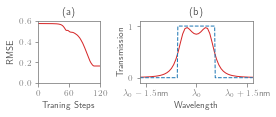

In [6]:
# result = np.load('crow/result.npy')
# losses = np.load('crow/losses.npy')
with custom_style():
    plt.figure(figsize=(3.9,1.7))
    plt.subplot2grid((1,5), (0,0), colspan=2)
    plt.plot(losses, label='RMSE')
    plt.xlim(0, 120)
    plt.xticks([0,60,120])
    plt.ylim(0, 0.6)
    plt.ylabel('RMSE')
    plt.xlabel('Traning Steps')
    plt.title('(a)')
    plt.subplot2grid((1,5), (0,2), colspan=3)
    crow.plot(result, label='detected')
    #plt.plot(wls.data.numpy(), target().data.numpy())
    plt.plot(wls.data.cpu().numpy(), target2().data.cpu().numpy(), '--', label='target')
    plt.xticks(
        [wl0 - 0.45 * domain, wl0, wl0 + 0.45 * domain],
        [r"$\lambda_0-1.5$nm", r"$\lambda_0$", r"$\lambda_0+1.5$nm"],
    )
    plt.yticks([0,1])
    plt.title('(b)')
    plt.ylim(-.1, 1.1)
    plt.xlim(wl0 - 0.5 * domain, wl0 + 0.5 * domain)
    plt.ylabel('Transmission')
    plt.xlabel('Wavelength')
    #plt.legend(loc='upper right', framealpha=0, prop={'size':7})
    plt.tight_layout()
    plt.show()